In [ ]:
!pip install transformers


In [6]:
#install hugging face evaluate 
!pip install evaluate

In [50]:
# imports 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer
from transformers import AutoTokenizer, BertForSequenceClassification

from transformers import pipeline

from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from huggingface_hub import notebook_login
from textwrap import wrap


import evaluate


from sklearn.metrics import confusion_matrix, classification_report  


In [8]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Read Data

# English Trainset
eng_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_csv/train_seg.csv") 

# English Validationset
eng_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_csv/val_seg.csv") 

# German Testset 
ger_testset=pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /test_german.csv")

In [15]:
#one-hot encoding the labels 
def to_sentiment(label):
  if label == True:
    return 1
  elif label == False:
    return 0

ger_testset['label'] = ger_testset['label'].apply(to_sentiment)
     

In [19]:
ger_testset['messages_de']

0        ['Rückseite', 'ok baby', 'was passiert Baby', ...
1        ['Hallo', 'Jungs sind Scheiß', 'dass sie', 'Ha...
2        ['Hallo', '19 m USA horny, u?', '2+2*2', '2+2*...
3        ['f/m?', 'Hallo', 'da', 'f', 'u?', 'Hallo', 'm...
4        ['tut mir leid, ich bin jetzt wieder.', 'und f...
                               ...                        
15324    ['Hallo', 'Hallo', 'Hey...', 'gut, das ist sel...
15325    ['Hallo', 'Asl?', 'heya was ist?', '13/f/socal...
15326    ['Guten Morgen, wie R U?', 'hey :)', 'Ich bin ...
15327    ['Hallo', 'm oder f', 'Hallo', 'f', '& u', ':)...
15328    ['ein Pferd ein Pferd', 'Brunnen Ober', 'null....
Name: messages_de, Length: 15329, dtype: object

**Train Multilingual BERT on English Data**

In [14]:
#load tokenizer and model 
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)



Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [20]:
#data to list
X_train = list(eng_trainset["segment"])
y_train = list(eng_trainset["label"])
X_val = list(eng_valset["segment"])
y_val = list(eng_valset["label"])
X_test = list(ger_testset["messages_de"])
y_test = list(ger_testset["label"])

In [21]:
#tokenize 
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)


In [22]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [23]:
#load the 3 dataset
train_dataset = Dataset(train_encodings, y_train)
val_dataset = Dataset(val_encodings, y_val)
test_dataset = Dataset(test_encodings, y_test)

In [37]:
# Define Trainer
args = TrainingArguments(
    output_dir="MultiModel_En_Gr",
    num_train_epochs=3,
    per_device_train_batch_size=16

)
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset)

In [27]:
#train
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.100400


TrainOutput(global_step=867, training_loss=0.06606276830037434, metrics={'train_runtime': 1296.913, 'train_samples_per_second': 10.666, 'train_steps_per_second': 0.669, 'total_flos': 3639615228794880.0, 'train_loss': 0.06606276830037434, 'epoch': 3.0})

In [35]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#push model to hub
trainer.push_to_hub()

**Test Multilingual BERT on German Data**


In [41]:
#get prediction from test data 
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
     

In [42]:
# macro f1 on test data 
metric = evaluate.load("f1")
metric.compute(predictions=preds, references=y_test,  average="macro")
     

{'f1': 0.4755514056520588}

In [43]:
class_names = [ 'non predator', 'predator']

In [44]:
#classification report

print(classification_report(y_test, preds, target_names=class_names))

              precision    recall  f1-score   support

non predator       0.90      1.00      0.95     13863
    predator       0.33      0.00      0.00      1466

    accuracy                           0.90     15329
   macro avg       0.62      0.50      0.48     15329
weighted avg       0.85      0.90      0.86     15329



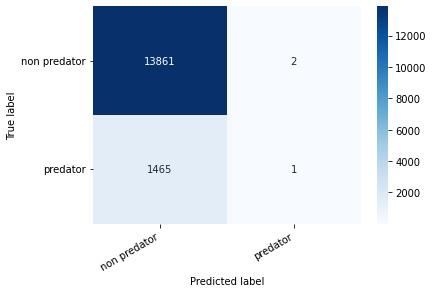

In [45]:
#confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [54]:
#example from the test data and its true and predicted labels
idx = 0
review_text = X_test[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds[idx]}')

     

['Rückseite', 'ok baby', 'was passiert Baby', 'Hund wollte heraus n
dann zog sie ab laufend die Straße hinunter', 'Oh Mann ich hasse das
was für eine Art von Gott?', 'Drahthund', 'ic ich habe einen Pitbull
er ist ein süßes Herz', 'kühle', 'er denkt, er sei ein kleiner Hund',
'lol', 'mag er 2 sit n ur lap?', 'wenn er seinen Weg hatte, würde er
es tun, aber er wird sich ausstrecken und die Couch übernehmen',
'lol', 'wollen seine Baby-Fotos sehen', 'AWWWWW', 'hes SOOOOO
niedlich!!', 'eine geöffnet', 'die anderen 2 nicht', 'ok', 'er ist so
klein', 'ja, aber nicht mehr', 'was machst du?', 'wo wo u wo und tun
Baby', 'Ich bin hier', ':) ok', '>:D<', '>:D<;;):-*', 'Sie wissen, was
Baby Ihr sssoooo allsome', 'Danke!', 'Scotland', 'Haben Sie Abendessen
noch gegessen?', 'ja ich bestellte papjohns pizza und u baby', 'werde
jetzt gehen essen', 'wird u b in später?', 'ok babby was du essest?',
'Hühner', 'mmm', 'bbl', ':-*', 'PO', 'ok', ':-*']

True label: predator

Predicted label: 0
